In [118]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import scipy.ndimage
from scipy import fftpack

In [139]:
def SNR(powerspecs):
    #Calculate Signal-to-Noise ratio given a set of powerspectra 
    
    powermean = np.mat(np.mean(powerspecs, axis = 0))
    powermat = np.vstack((powerspecs))
    covar = np.mat(np.cov(powerspecs, rowvar = 0))
    
    SNRsquare = powermean * (covar.I * powermean.T)
    
    return np.sqrt(SNRsquare)

In [120]:
def power1D(image, num_bins):
    
    y, x = np.indices(image.shape)
    center = np.array([(x.max() - x.min()) / 2., (x.max() - x.min()) / 2.])
    
    if image.shape[0] % 2 == 0:
        center += 0.5
    
    radii = np.hypot(x - center[0], y - center[1])
    
    sorted_radii_indices = np.argsort(radii.flat)
    sorted_radii = radii.flat[sorted_radii_indices]
    sorted_pixels = image.flat[sorted_radii_indices]
    
    bins = np.logspace(0, np.log10(image.shape[0]/2.), num_bins + 1)
    
    bin_weights = np.histogram(sorted_radii, bins)[0]
    bin_edges = np.cumsum(bin_weights)
    pixel_sums = np.cumsum(sorted_pixels, dtype=float)
    bin_totals = pixel_sums[bin_edges[1:] - 1] - pixel_sums[bin_edges[:-1] - 1]
    radial_prof = bin_totals/bin_weights[1:]
    
    return bins[1:], radial_prof

def PowerSpectrum(psd2D, sizedeg = 12.25, size = 2048, bins = 50):
    
    ells, psd1D = power1D(psd2D, num_bins = 50)
    
    edge2center = lambda x: x[:-1]+0.5*(x[1:]-x[:-1])
    ells = edge2center(ells)
    
    ells *= 360. / np.sqrt(sizedeg)
    norm = ((2 * np.pi * np.sqrt(sizedeg) / 360.0) ** 2) / (size ** 2) ** 2
    powspec = ells * (ells + 1) / (2 * np.pi) * norm * psd1D
    
    last_nan = np.where(np.isnan(powspec))[0][-1]
    ells = ells[last_nan + 1:]
    powspec = powspec[last_nan + 1:]
    return ells, powspec

In [121]:
image_1 = fits.open('file:///C:/cygwin64/home/rehg98/WLconv_z1100.00_0580r.fits')[0].data.astype(float)
image_1 = scipy.ndimage.filters.gaussian_filter(image_1, 9.75)
F_1 = fftpack.fftshift(fftpack.fft2(image_1))
psd2D_1 = np.abs(F_1)**2
ell_1, powspec_1 = PowerSpectrum(psd2D_1, sizedeg = 12.25, size = 2048, bins = 50)

C:\Users\rehg98\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [122]:
image_2 = fits.open('file:///C:/cygwin64/home/rehg98/WLconv_z1100.00_0007r.fits')[0].data.astype(float)
image_2 = scipy.ndimage.filters.gaussian_filter(image_2, 9.75)
F_2 = fftpack.fftshift(fftpack.fft2(image_2))
psd2D_2 = np.abs(F_2)**2
ell_2, powspec_2 = PowerSpectrum(psd2D_2, sizedeg = 12.25, size = 2048, bins = 50)

C:\Users\rehg98\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


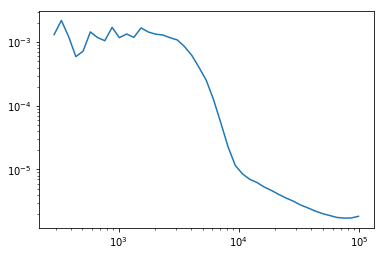

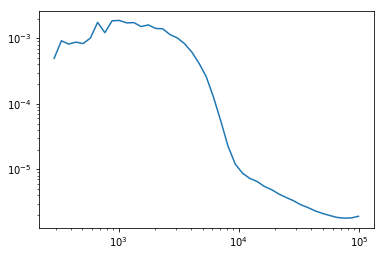

In [123]:
plt.loglog(ell_1, powspec_1)
plt.show()

plt.loglog(ell_2, powspec_2)
plt.show()

In [140]:
powspecs = np.array([powspec_1, powspec_2])
print(SNR(powspecs))

[[  9.08552802e-04   1.56101710e-03   1.02326386e-03   7.35629741e-04
    7.80394589e-04   1.23190510e-03   1.47151107e-03   1.14096710e-03
    1.78767052e-03   1.53069385e-03   1.53731471e-03   1.46910540e-03
    1.59822333e-03   1.52808597e-03   1.38161201e-03   1.34976653e-03
    1.15990038e-03   1.05212558e-03   8.41398881e-04   6.19760979e-04
    4.08452852e-04   2.54792045e-04   1.25484760e-04   5.43249627e-05
    2.26156738e-05   1.17658623e-05   8.60333315e-06   7.13391301e-06
    6.37171234e-06   5.38144851e-06   4.78088292e-06   4.12387399e-06
    3.63716432e-06   3.24868731e-06   2.82528780e-06   2.54940596e-06
    2.27322922e-06   2.07336456e-06   1.93085256e-06   1.80278473e-06
    1.75645660e-06   1.76569362e-06   1.87504194e-06]]
[[ -1.02112703e+21  -1.02072473e+21   1.87907965e+22 ...,   1.11875389e+25
   -2.29800588e+25  -2.98841178e+25]
 [ -1.43164092e+21  -2.17278664e+21  -6.07551752e+21 ...,   4.71900944e+25
    9.76018430e+25  -9.72755820e+25]
 [  1.62919639e+20   